   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


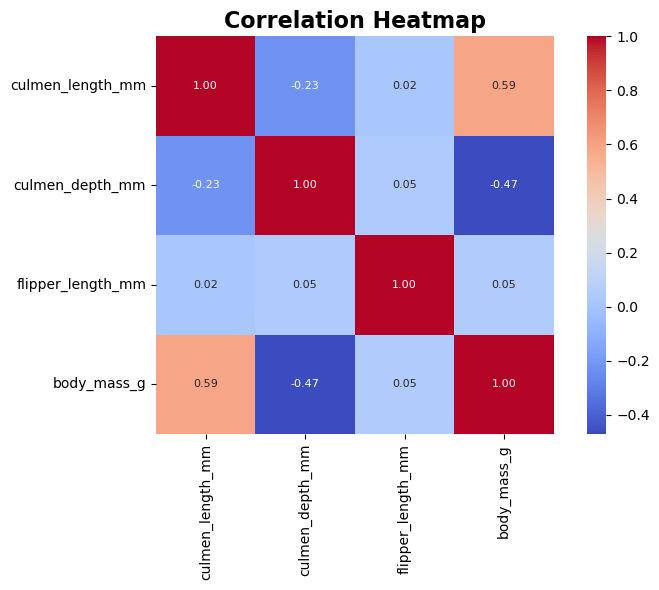

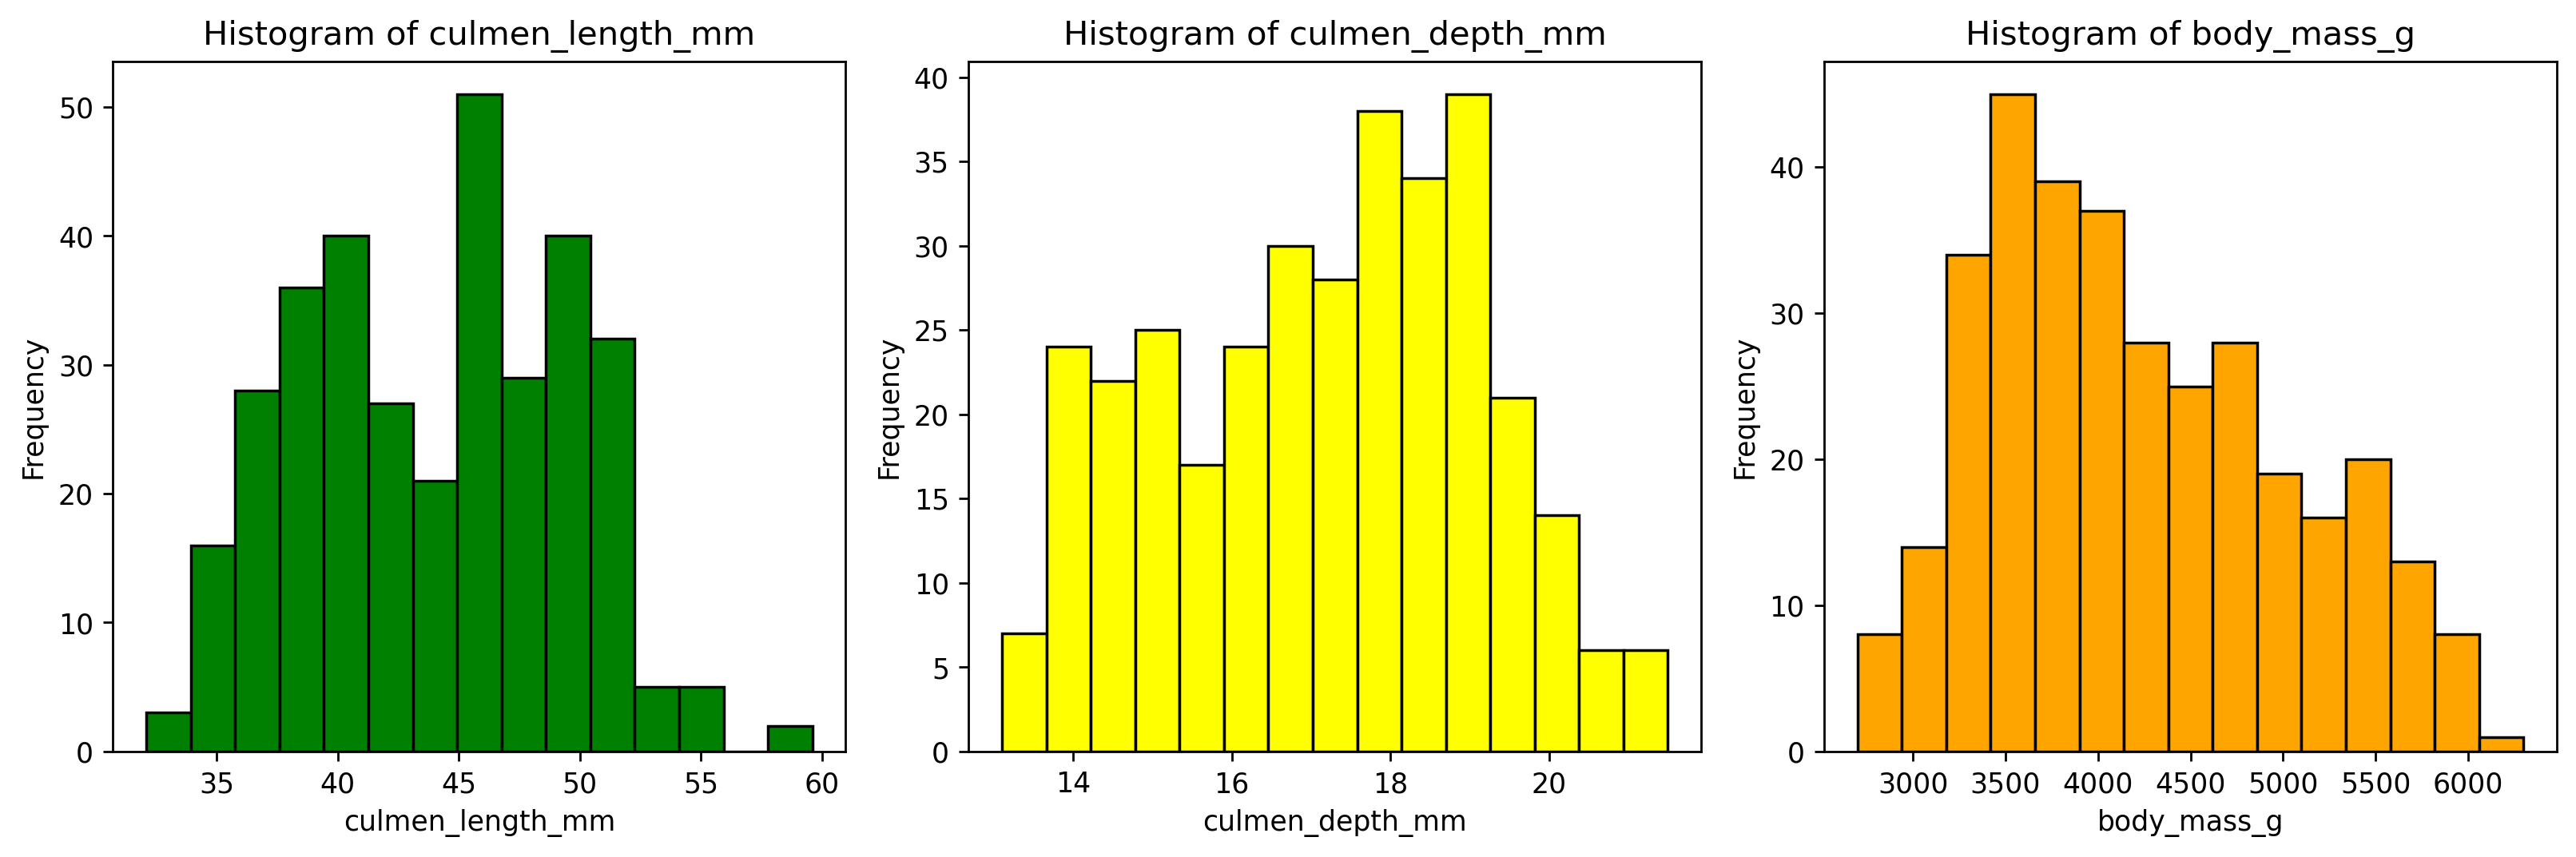

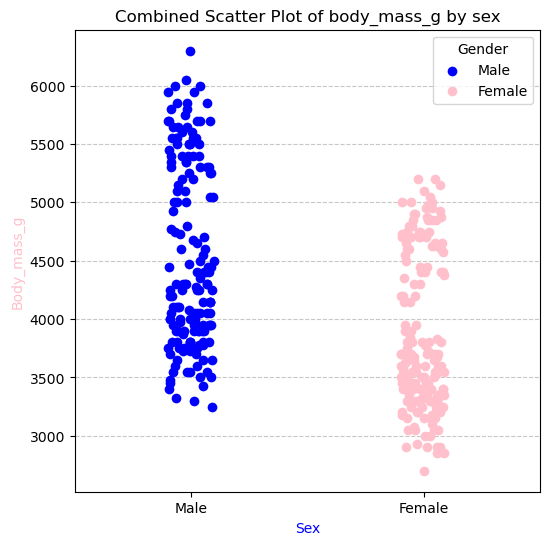

Number of components with more than 10% variance: 3


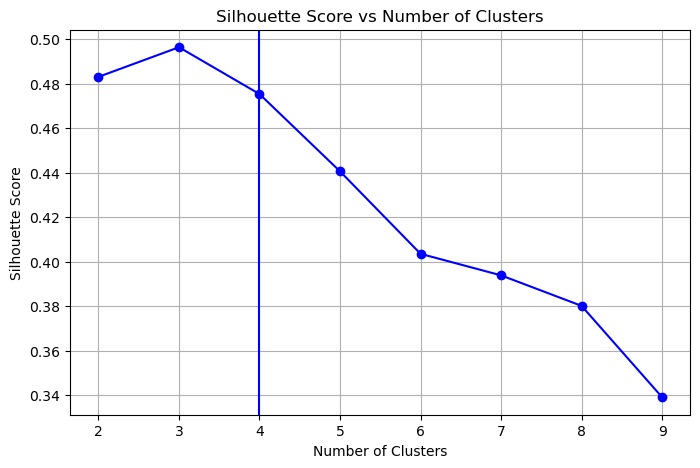

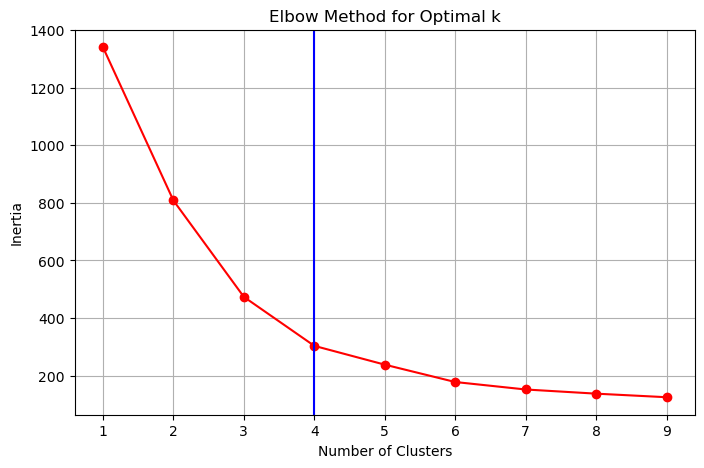

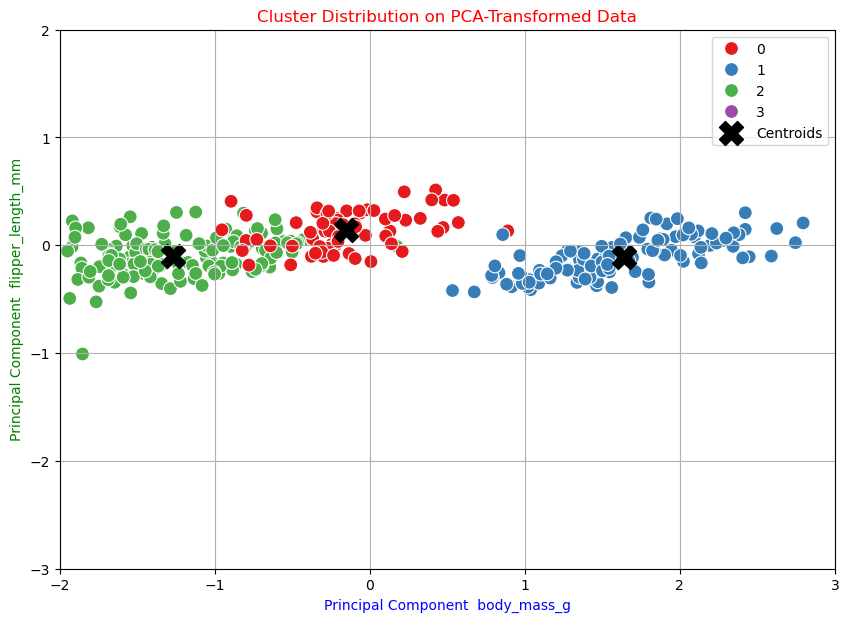

In [135]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
import math
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

#scatter plot
def scatter_plot_combined(dataframe, numerical_column, categorical_column):
    """
    Create a combined scatter plot for male and female entries based on a categorical column.

    Parameters:
    dataframe : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    numerical_column : str
        The name of the numerical column (y-axis).
    categorical_column : str
        The name of the categorical column used to filter the data
    """
    dataframe[categorical_column] = dataframe[categorical_column].str.strip().str.capitalize()
    male_data = dataframe[dataframe[categorical_column] == 'Male']
    female_data = dataframe[dataframe[categorical_column] == 'Female']
    plt.figure(figsize=(6, 6))
    sns.stripplot(data=male_data, x=categorical_column, y=numerical_column, jitter=True, color="blue", label="Male", size=7)
    sns.stripplot(data=female_data, x=categorical_column, y=numerical_column, jitter=True, color="pink", label="Female", size=7)
    plt.title(f'Combined Scatter Plot of {numerical_column} by {categorical_column}')
    plt.xlabel(categorical_column.capitalize(),color='blue')
    plt.ylabel(numerical_column.capitalize(),color='pink')
    plt.legend(title="Gender")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


#coorelation matrix
def plot_correlation_heatmap(data):
    """
    Plot a heatmap showing correlations between numerical features.

    Parameters:
    data (DataFrame): Dataset to analyze.
    """
    numeric_data = data.select_dtypes(include='number')
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",cbar=True, square=True, annot_kws={"size": 8})  # Increase font size for annotations
    plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

#histogram
def plot_colored_histograms(dataframe, columns, colors=None, bins=10):
    """
    Plot individual histograms for a list of numerical columns with customizable colors.

    Parameters:
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    columns : list of str
        The list of numerical column names to create histograms for.
    colors : list of str, optional
        A list of colors for the histograms. If not provided, default matplotlib colors are used.
    bins : int, optional
        Number of bins for the histogram (default is 10).
    """
    plt.figure(figsize=(13, 8), dpi=250)
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i + 1)  # Adjust subplot layout (2 rows, 3 columns)
        plt.hist(dataframe[col], bins=bins, color=colors[i] if colors else 'blue', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout() 
    plt.show()



#calculate statics of all numeric data
def calculate_numeric_statistics(df):
    """
    Calculate summary statistics for numeric columns in the DataFrame.

    This function computes the following statistics for each numeric column:
    - Count,Mean,Standard Deviation,Min,25th percentile,50th percentile (Median),75th percentile,Max
    - Skewness,Kurtosis

    Parameters:df (pandas.DataFrame): The input DataFrame containing numeric columns.
    Returns:pandas.DataFrame: A DataFrame containing the computed statistics.
    """
    num_columns = df.select_dtypes(include=['int', 'float']).columns
    summary_stats = df[num_columns].describe().transpose()
    median_values = df[num_columns].median()
    skew_values = df[num_columns].skew()
    kurt_values = df[num_columns].kurtosis()
    stats_df = pd.concat([summary_stats, median_values, skew_values, kurt_values], axis=1)
    stats_df.columns = ['Count', 'Mean', 'Std Dev', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Kurtosis', 'Median']
    return stats_df



def standardize_data(dataframe):
    """
    Standardize the input data using StandardScaler.
    
    Parameters:
    dataframe : pandas.DataFrameThe input DataFrame containing numerical data to be standardized.

    Returns:
    scaled_data : numpy.ndarray  The standardized data.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)
    return scaled_data


def apply_pca(scaled_data):
    """
    Apply Principal Component Analysis (PCA) to reduce the dimensionality of the data.
    
    Parameters:
    scaled_data : numpy.ndarray The standardized data.

    Returns:
    pca_transformed_data : numpy.ndarray Data transformed using PCA.
    explained_variance : numpy.ndarray Explained variance ratio for each PCA component.
    """
    pca = PCA(n_components=None)
    pca_transformed_data = pca.fit_transform(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    return pca_transformed_data, explained_variance


def elbow_analysis(pca_transformed_data, max_clusters=10):
    """
    Perform Elbow analysis to determine the optimal number of clusters.
    
    Parameters:
    pca_transformed_data : numpy.ndarrayThe PCA-transformed data.
    max_clusters : int, optional The maximum number of clusters to consider for the analysis (default is 10).

    Returns:
    optimal_clusters : int
        Optimal number of clusters based on the analysis.
    """
    inertia_list = []
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pca_transformed_data)
        inertia_list.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters), inertia_list, 'ro-')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.axvline(x=4, color='b', linestyle='-')  # Example optimal k
    plt.show()
    return 4


def silhouette_analysis(pca_transformed_data, max_clusters=10):
    """
    Perform Silhouette analysis to evaluate clustering quality.
    
    Parameters:
    pca_transformed_data : numpy.ndarray
        The PCA-transformed data.
    max_clusters : int, optional
        The maximum number of clusters to consider for the analysis (default is 10).
    """
    silhouette_scores = []
    for n_clusters in range(2, max_clusters):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pca_transformed_data)
        silhouette = silhouette_score(pca_transformed_data, labels)
        silhouette_scores.append(silhouette)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters), silhouette_scores, 'bo-')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.axvline(x=4, color='b', linestyle='-')  # Example optimal k
    plt.grid()
    plt.show()


def kmeans_clustering(dataframe, pca_transformed_data, n_clusters):
    """
    Perform KMeans clustering on the PCA-transformed data and visualize the results.
    
    Parameters:
    dataframe : pandas.DataFrame
        The original DataFrame to store cluster labels.
    pca_transformed_data : numpy.ndarray
        The PCA-transformed data.
    n_clusters : int
        Number of clusters for KMeans.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pca_transformed_data)
    dataframe['Cluster'] = kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=pca_transformed_data[:, 0],
        y=pca_transformed_data[:, 1],
        hue=kmeans.labels_,
        palette='Set1',
        s=100,
        legend="full"
    )
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', label='Centroids')
    plt.title('Cluster Distribution on PCA-Transformed Data',color='red')
    plt.xlabel('Principal Component  body_mass_g',color='blue')
    plt.ylabel('Principal Component  flipper_length_mm',color='green')
    plt.xlim(-2,3)
    plt.ylim(-3,2)
    plt.legend()
    plt.grid()
    plt.show()


#
###______________________############
df=pd.read_csv('penguins.csv')
print(df.head())
df = df.dropna()
print(df.isnull().sum())
plot_correlation_heatmap(df)
numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'body_mass_g']
custom_colors = ['green', 'yellow', 'orange']
plot_colored_histograms(df, numerical_columns, colors=custom_colors, bins=15)
scatter_plot_combined(df, numerical_column='body_mass_g', categorical_column='sex')
calculate_numeric_statistics(df)


df.drop(columns=['sex'], inplace=True)

# Standardize the data
scaled_data = standardize_data(df)

# Apply PCA
pca_transformed_data, explained_variance = apply_pca(scaled_data)

# Print PCA components with more than 10% variance
n_components_above_10 = sum(explained_variance > 0.1)
print(f"Number of components with more than 10% variance: {n_components_above_10}")

# Perform Silhouette analysis
silhouette_analysis(pca_transformed_data, max_clusters=10)

# Perform Elbow analysis and get optimal clusters
optimal_clusters = elbow_analysis(pca_transformed_data)

# Perform clustering and visualize
kmeans_clustering(df, pca_transformed_data, optimal_clusters)